In [3]:
package_path = "./input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/"
import sys 
sys.path.append(package_path)

import os
import glob
import time
import random

import numpy as np
import pandas as pd

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils import data as torch_data
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import efficientnet_pytorch

from sklearn.model_selection import StratifiedKFold

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 123
torch.cuda.set_device(3)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

class CFG:
    img_size = 256
    n_frames = 10
    
    cnn_features = 256
    lstm_hidden = 32
    
    n_fold = 5
    n_epochs = 15

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.map = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=1)
        self.map1 = nn.Conv2d(in_channels = 4 , out_channels = 1 , kernel_size = 1 )
        self.map2 = nn.Conv2d(in_channels = 4 , out_channels = 1 , kernel_size = 1 )
        self.map3 = nn.Conv2d(in_channels = 4 , out_channels = 1 , kernel_size = 1 ) 
        self.FT = nn.Conv2d(in_channels = 4 , out_channels = 3 , kernel_size = 1 )
        self.net = efficientnet_pytorch.EfficientNet.from_name("efficientnet-b0")
        checkpoint = torch.load("./input/efficientnet-pytorch/efficientnet-b0-08094119.pth")
        self.net.load_state_dict(checkpoint)
        
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=CFG.cnn_features, bias=True)
    
    def forward(self, x):
        x1 = F.relu(self.map(x))
        x2= F.relu(self.map1(x))
        x3 = F.relu(self.map2(x))
        x4 = F.relu(self.map3(x))
        x_cat = torch.cat((x1, x2, x3, x4),dim = 1)
        net_in = F.relu(self.FT(x_cat))
        out = self.net(net_in)
        return out

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cnn = CNN()
        self.rnn = nn.LSTM(CFG.cnn_features, CFG.lstm_hidden, 2, batch_first=True)
        self.fc = nn.Linear(CFG.lstm_hidden, 1, bias=True)

    def forward(self, x):
        # x shape: BxTxCxHxW
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        output, (hn, cn) = self.rnn(r_in)
        
        out = self.fc(hn[-1])
        return out


In [4]:
def load_image(path):
    image = cv2.imread(path, 0)
    if image is None:
        return np.zeros((CFG.img_size, CFG.img_size))
    
    image = cv2.resize(image, (CFG.img_size, CFG.img_size)) / 255
    return image.astype('f')

def uniform_temporal_subsample(x, num_samples):
    '''
        Moddified from https://github.com/facebookresearch/pytorchvideo/blob/d7874f788bc00a7badfb4310a912f6e531ffd6d3/pytorchvideo/transforms/functional.py#L19
        Args:
            x: input list
            num_samples: The number of equispaced samples to be selected
        Returns:
            Output list     
    '''
    t = len(x)
    indices = torch.linspace(0, t - 1, num_samples)
    indices = torch.clamp(indices, 0, t - 1).long()
    return [x[i] for i in indices]

In [6]:
df = pd.read_csv("./input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(
                                    shift_limit=0.0625, 
                                    scale_limit=0.1, 
                                    rotate_limit=10, 
                                    p=0.5
                                ),
                                A.RandomBrightnessContrast(p=0.5),
                            ])
valid_transform = A.Compose([
                            ])

------------------------------
Fold 1
EPOCH: 1
[Epoch Train: 1] loss: 0.69318, score: 0.52350, time: 487 s
[Epoch Valid: 1] loss: 0.69196, score: 0.55556, time: 110 s
The score improved from -inf to 0.55556. Save model to 'best-model-1.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.68501, score: 0.56410, time: 508 s
[Epoch Valid: 2] loss: 0.69104, score: 0.49573, time: 120 s
EPOCH: 3
[Epoch Train: 3] loss: 0.67906, score: 0.56197, time: 475 s
[Epoch Valid: 3] loss: 0.69375, score: 0.46154, time: 30 s
EPOCH: 4
[Epoch Train: 4] loss: 0.68057, score: 0.58547, time: 61 s7
[Epoch Valid: 4] loss: 0.69130, score: 0.52137, time: 9 s
EPOCH: 5
[Epoch Train: 5] loss: 0.67636, score: 0.57692, time: 60 s1
[Epoch Valid: 5] loss: 0.69378, score: 0.52991, time: 10 s
EPOCH: 6
[Epoch Train: 6] loss: 0.67504, score: 0.58547, time: 58 s1
[Epoch Valid: 6] loss: 0.69041, score: 0.54701, time: 9 s
EPOCH: 7
[Epoch Train: 7] loss: 0.67377, score: 0.57051, time: 60 s2
[Epoch Valid: 7] loss: 0.70090, score: 0.51282, tim

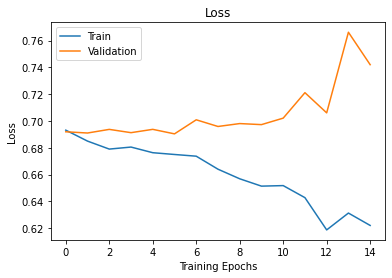

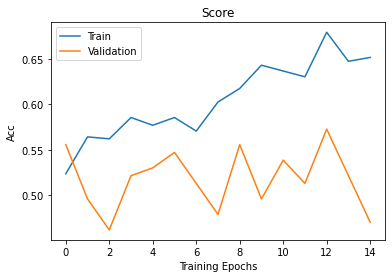

------------------------------
Fold 2
EPOCH: 1
[Epoch Train: 1] loss: 0.69303, score: 0.51923, time: 399 s
[Epoch Valid: 1] loss: 0.70340, score: 0.47009, time: 115 s
The score improved from -inf to 0.47009. Save model to 'best-model-2.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.68034, score: 0.58333, time: 471 s
[Epoch Valid: 2] loss: 0.69495, score: 0.47863, time: 102 s
The score improved from 0.47009 to 0.47863. Save model to 'best-model-2.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.67012, score: 0.61111, time: 481 s
[Epoch Valid: 3] loss: 0.68391, score: 0.57265, time: 103 s
The score improved from 0.47863 to 0.57265. Save model to 'best-model-2.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.65561, score: 0.64744, time: 460 s
[Epoch Valid: 4] loss: 0.68483, score: 0.52137, time: 87 s
EPOCH: 5
[Epoch Train: 5] loss: 0.64894, score: 0.64957, time: 499 s
[Epoch Valid: 5] loss: 0.72622, score: 0.47009, time: 89 s
EPOCH: 6
[Epoch Train: 6] loss: 0.66158, score: 0.62393, time: 498 s
[Epoch Valid: 6] loss:

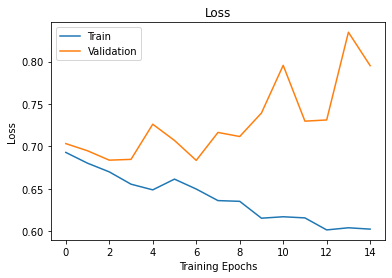

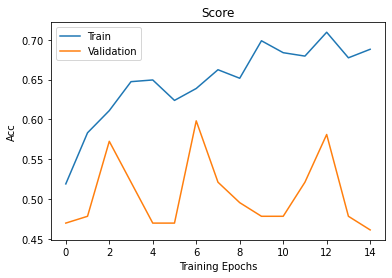

------------------------------
Fold 3
EPOCH: 1
[Epoch Train: 1] loss: 0.69347, score: 0.51282, time: 438 s
[Epoch Valid: 1] loss: 0.68729, score: 0.62393, time: 121 s
The score improved from -inf to 0.62393. Save model to 'best-model-3.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.69160, score: 0.52350, time: 470 s
[Epoch Valid: 2] loss: 0.69102, score: 0.47863, time: 121 s
EPOCH: 3
[Epoch Train: 3] loss: 0.68751, score: 0.53632, time: 398 s
[Epoch Valid: 3] loss: 0.69333, score: 0.47863, time: 156 s
EPOCH: 4
[Epoch Train: 4] loss: 0.67558, score: 0.59829, time: 448 s
[Epoch Valid: 4] loss: 0.69975, score: 0.47863, time: 128 s
EPOCH: 5
[Epoch Train: 5] loss: 0.68211, score: 0.55342, time: 420 s
[Epoch Valid: 5] loss: 0.68846, score: 0.55556, time: 133 s
EPOCH: 6
[Epoch Train: 6] loss: 0.68054, score: 0.58547, time: 451 s
[Epoch Valid: 6] loss: 0.69078, score: 0.53846, time: 119 s
EPOCH: 7
[Epoch Train: 7] loss: 0.66858, score: 0.58547, time: 502 s
[Epoch Valid: 7] loss: 0.68843, score: 0.5042

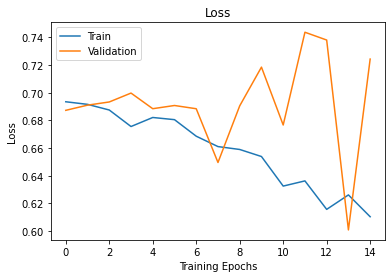

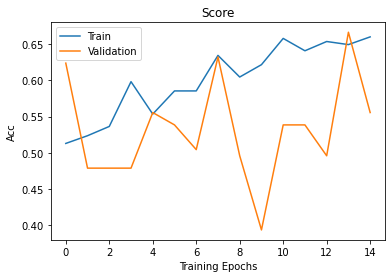

------------------------------
Fold 4
EPOCH: 1
[Epoch Train: 1] loss: 0.69104, score: 0.48077, time: 540 s
[Epoch Valid: 1] loss: 0.69800, score: 0.47863, time: 127 s
The score improved from -inf to 0.47863. Save model to 'best-model-4.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.67400, score: 0.60684, time: 530 s
[Epoch Valid: 2] loss: 0.69835, score: 0.48718, time: 132 s
The score improved from 0.47863 to 0.48718. Save model to 'best-model-4.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.67396, score: 0.59188, time: 496 s
[Epoch Valid: 3] loss: 0.69205, score: 0.52137, time: 145 s
The score improved from 0.48718 to 0.52137. Save model to 'best-model-4.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.67183, score: 0.58333, time: 498 s
[Epoch Valid: 4] loss: 0.70676, score: 0.52991, time: 187 s
The score improved from 0.52137 to 0.52991. Save model to 'best-model-4.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.65756, score: 0.61325, time: 488 s
[Epoch Valid: 5] loss: 0.73653, score: 0.52991, time: 161 s
EPOCH: 6
[Ep

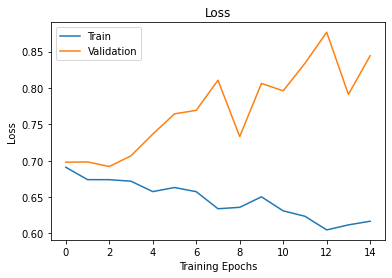

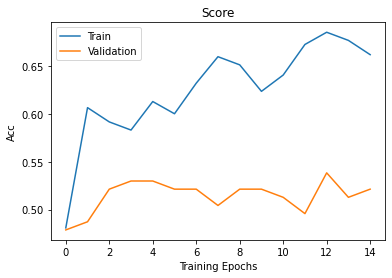

------------------------------
Fold 5
EPOCH: 1
[Epoch Train: 1] loss: 0.69228, score: 0.51068, time: 542 s
[Epoch Valid: 1] loss: 0.69801, score: 0.47863, time: 152 s
The score improved from -inf to 0.47863. Save model to 'best-model-5.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.68533, score: 0.56838, time: 541 s
[Epoch Valid: 2] loss: 0.69166, score: 0.56410, time: 203 s
The score improved from 0.47863 to 0.56410. Save model to 'best-model-5.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.67319, score: 0.60470, time: 527 s
[Epoch Valid: 3] loss: 0.68936, score: 0.52137, time: 146 s
EPOCH: 4
[Epoch Train: 4] loss: 0.67318, score: 0.59188, time: 579 s
[Epoch Valid: 4] loss: 0.68442, score: 0.52991, time: 103 s
EPOCH: 5
[Epoch Train: 5] loss: 0.66732, score: 0.60897, time: 578 s
[Epoch Valid: 5] loss: 0.68399, score: 0.53846, time: 102 s
EPOCH: 6
[Epoch Train: 6] loss: 0.65630, score: 0.65171, time: 525 s
[Epoch Valid: 6] loss: 0.69433, score: 0.55556, time: 116 s
EPOCH: 7
[Epoch Train: 7] loss: 0.662

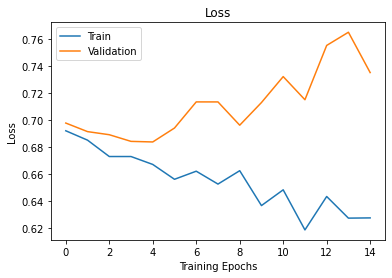

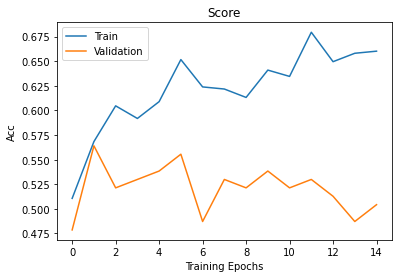


Training complete in 723m 7s
Avg loss 0.7117771583795548
Avg score 0.5880341880341879


In [10]:
class DataRetriever(Dataset):
    def __init__(self, paths, targets, transform=None):
        self.paths = paths
        self.targets = targets
        self.transform = transform
          
    def __len__(self):
        return len(self.paths)
    
    def read_video(self, vid_paths):
        video = [load_image(path) for path in vid_paths]
      #  import pdb;pdb.set_trace()
        if self.transform:
            seed = random.randint(0,99999)
            for i in range(len(video)):
                random.seed(seed)
                video[i] = self.transform(image=video[i])["image"]
        
        video = [torch.tensor(frame, dtype=torch.float32) for frame in video]
        if len(video)==0:
            video = torch.zeros(CFG.n_frames, CFG.img_size, CFG.img_size)
        else:
            video = torch.stack(video) # T * C * H * W
#         video = torch.transpose(video, 0, 1) # C * T * H * W
        return video
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = f"./input/rsna-miccai-png/train/{str(_id).zfill(5)}/"
        channels = []
        for t in ["FLAIR", "T1w", "T1wCE", "T2w"]:
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            num_samples = CFG.n_frames
            if len(t_paths) < num_samples:
                in_frames_path = t_paths
            else:
                in_frames_path = uniform_temporal_subsample(t_paths, num_samples)
            
            channel = self.read_video(in_frames_path)
            if channel.shape[0] == 0:
                print("1 channel empty")
                channel = torch.zeros(num_samples, CFG.img_size, CFG.img_size)
            channels.append(channel)
            
        channels = torch.stack(channels).transpose(0,1)
        
        y = torch.tensor(self.targets[index], dtype=torch.float)
        return {"X": channels.float(), "y": y}
    

class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        self.hist = {'val_loss':[],
                     'val_score':[],
                     'train_loss':[],
                     'train_score':[]
                    }
        
        self.best_valid_score = -np.inf
        self.best_valid_loss = np.inf
        self.n_patience = 0
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            self.hist['val_loss'].append(valid_loss)
            self.hist['train_loss'].append(train_loss)
            self.hist['val_score'].append(valid_score)
            self.hist['train_score'].append(train_score)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )

            if self.best_valid_score < valid_score:
                self.info_message(
                    self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                )
                self.best_valid_score = valid_score
                self.best_valid_loss = valid_loss
                self.save_model(n_epoch, save_path)
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
                
        return self.best_valid_loss, self.best_valid_score
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}'
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def plot_loss(self):
        plt.title("Loss")
        plt.xlabel("Training Epochs")
        plt.ylabel("Loss")

        plt.plot(self.hist['train_loss'], label="Train")
        plt.plot(self.hist['val_loss'], label="Validation")
        plt.legend()
        plt.show()
    
    def plot_score(self):
        plt.title("Score")
        plt.xlabel("Training Epochs")
        plt.ylabel("Acc")

        plt.plot(self.hist['train_score'], label="Train")
        plt.plot(self.hist['val_score'], label="Validation")
        plt.legend()
        plt.show()
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)


skf = StratifiedKFold(n_splits=CFG.n_fold)
t = df['MGMT_value']

start_time = time.time()

losses = []
scores = []

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(t)), t), 1):
    print('-'*30)
    print(f"Fold {fold}")
    
    train_df = df.loc[train_index]
    val_df = df.loc[val_index]
    train_retriever = DataRetriever(
        train_df["BraTS21ID"].values, 
        train_df["MGMT_value"].values,
        train_transform
    )
    val_retriever = DataRetriever(
        val_df["BraTS21ID"].values, 
        val_df["MGMT_value"].values
    )
    train_loader = torch_data.DataLoader(
        train_retriever,
        batch_size=8,
        shuffle=True,
        num_workers=0,
    )
    valid_loader = torch_data.DataLoader(
        val_retriever, 
        batch_size=8,
        shuffle=False,
        num_workers=0,
    )
    
    model = Model()
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = F.binary_cross_entropy_with_logits
    
    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion, 
        LossMeter, 
        AccMeter
    )
    loss, score = trainer.fit(
        CFG.n_epochs, 
        train_loader, 
        valid_loader, 
        f"best-model-{fold}.pth", 
        100,
    )
    losses.append(loss)
    scores.append(score)
    
    trainer.plot_loss()
    trainer.plot_score()
    
elapsed_time = time.time() - start_time
print('\nTraining complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))
print('Avg loss {}'.format(np.mean(losses)))
print('Avg score {}'.format(np.mean(scores)))